# **Dependencies and imports**

This can take a minute...

https://arena-chapter2-rl.streamlit.app/[2.2]_Q-Learning_and_DQN

In [214]:
# https://github.com/robert-lieck/rldurham/tree/main - rldurham repo

# !pip install swig
# !pip install --upgrade rldurham
# !pip install torchinfo

In [215]:
import math
import random
import copy

import numpy as np # consider switching out for torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Distribution, Normal
import rldurham as rld

# from torchinfo import summary

# **RL agent**

In [216]:
MAX_TIMESTEPS = 2000

## helper fns

In [217]:
# HELPERS
# for https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# def evaluate_policy(env, agent, turns=3):
#     total_scores = 0
#     for i in range(turns):
#         s, _ = env.reset()
#         for t in range(2000): # 2000 = max_timesteps (TODO - diff from Jinghao's imp)
#             # Take deterministic actions at test time
#             a = agent.select_action(s, deterministic=True)
#             s_next, r, dw, tr, _ = env.step(a)
#             done = (dw or tr)

#             total_scores += r
#             s = s_next

#             if done:
#                 break

#     return int(total_scores / turns)

# def adapt_reward(r):
#     """Reward engineering for better training."""
#     # For BipedalWalker (both versions)
#     if r <= -100:
#         r = -1
#     return r

In [218]:
# HELPERs
# for https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

# abstracted training loop function for both environments to use.
# the real environment will always have MAX_TIMESTEPS as the max_timesteps value
# while the dreamer enviroment might have less timesteps
def train_on_environment(actor, env, class_to_take_gradient_step,
 replay_buffer, max_timesteps, state, batch_size, total_steps, sequence_length):
    ep_timesteps = 0
    ep_reward = 0
    input_buffer = torch.empty((0, 54)) # save start sequence for the dreamer model TODO - where does 54 come from?

    for t in range(max_timesteps): 
        total_steps += 1
        # select action and step the env
        action = actor.select_action(state)
        step = env.step(action)

        # handle different return formats
        if len(step) == 5:
            next_state, reward, term, tr, info = step
            done = term or tr
        else:
            print("step length is not 5")
            next_state, reward, done, info = step

        ep_timesteps += 1
        ep_reward += reward

        # change reward of real environment
        if max_timesteps == MAX_TIMESTEPS: # i.e. if real environment? TODO - can dreamers possibly have max_timesteps?
            # reward design NOTE justify!
            if reward == -100.0:
                reward = -10.0
            else:
                reward *= 2
            replay_buffer.add(state, action, next_state, reward, done)

        else: # must be dreamer env
            if t == sequence_length:
                for row in input_buffer.cpu().numpy():
                    replay_buffer.add(row[:24], row[24:28], row[28:52], row[52], row[53])
                    # TODO - why does this ^ use slices? Where do these numbers come from?
            elif t > sequence_length:
                replay_buffer.add(state, action, next_state, reward, done)
            # NOTE - don't store if simulation ends without reaching the sequence length
        
        if t < sequence_length: # store in input buffer TODO what does this do? why's it needed?
            input_buffer = torch.cat([
                input_buffer,
                torch.tensor(
                    np.concatenate((state, action, next_state, np.array([reward]), np.array([done])),
                    axis=0)
                    ).unsqueeze(0)
                ], axis=0)        
    
        state = next_state
        
        if total_steps >= batch_size: # do 1 training update using 1 batch from buffer
            # train the agent using experiences from the real environment
            class_to_take_gradient_step.take_gradient_step(replay_buffer, t, batch_size)
    
        if done: # break if ep finished
            break

    if sequence_length > 0: # TODO - this means...? which env are we in?
        return ep_timesteps, ep_reward, input_buffer, info
    return ep_timesteps, ep_reward, None, info


# test loop for agent on environment
def simulate_on_environment(actor, env, max_timesteps, state):
    ep_timesteps = 0
    ep_reward = 0
    for t in range(max_timesteps):
        action = actor.select_action(state)
        step = env.step(action)
        if len(step) == 5:
            next_state, reward, term, tr, _ = step
            done = term or tr
        else:
            next_state, reward, done, _ = step
        ep_timesteps += 1
    
        state = next_state
        ep_reward += reward
    
        if done or t == max_timesteps - 1:
            break
    return ep_timesteps, ep_reward

# generate value array from replay buffer
def retrieve_from_replay_buffer(replay_buffer, ptr):
    '''
    '''
    return np.concatenate((
                    replay_buffer.state[ptr:replay_buffer.ptr],
                    replay_buffer.action[ptr:replay_buffer.ptr],
                    replay_buffer.reward[ptr:replay_buffer.ptr],
                    1. - replay_buffer.not_done[ptr:replay_buffer.ptr],
                    replay_buffer.next_state[ptr:replay_buffer.ptr],                
                ), 
                axis = 1 # along the columns (so each row is a memory)
            )

# function to create sequences with a given window size and step size
def create_sequences(memories, window_size, step_size):
    '''
    Function to create sequences of memories from the replay buffer.

    Each sequence is of length window_size and each spaced apart by step_size
    '''
    n_memories = memories.shape[0] # just the number of time steps currently in the buffer

    # calc number of seq (of len window_size) we can create from mems available  
    n_sequences = math.floor((n_memories - window_size) / step_size) + 1 # +1 because indices start at 0

    sequences = np.zeros((n_sequences, window_size, memories.shape[1]))
    for i in range(n_sequences):
        start_idx = i * step_size # idx to start seq from
        sequences[i, :] = memories[start_idx:start_idx + window_size, :] # grab seq of memories window_size long from start_idx
    return sequences

def gen_test_train_seq(replay_buffer, train_set, test_set, train_split, window_size, step_size, ptr):
    '''
    Function to split train and test data
    '''
    memories = retrieve_from_replay_buffer(replay_buffer, ptr)
    try:
        memory_sequences = create_sequences(memories, window_size, step_size)
        n_sequences = memory_sequences.shape[0]
    except: # TODO How might this go wrong? not enough new data to create a sequence?
        return train_set, test_set

    # shuffle the sequences & split
    indices = np.arange(n_sequences)
    np.random.shuffle(indices)

    split = int(train_split * n_sequences) # get split point 
    train_indices = indices[:split]
    test_indices = indices[split:]

    if train_set is None: # if this is first train/test set, create the sets
        return memory_sequences[train_indices, :], memory_sequences[test_indices, :]
    # else just add to existing sets
    return np.concatenate((train_set, memory_sequences[train_indices, :]), axis=0), np.concatenate((test_set, memory_sequences[test_indices, :]), axis=0)

In [219]:
def gen_dreamer_eps(dreamer_avg_loss, score_threshold):
    '''
    Get number of dreamed episdoes the agent should run on the dreamer model.

    Only use dreamer for trainibg if it's sufficiently accurate model of env.

    Note - score_threshold is between 0 and 1.
    '''
    max_dreamer_it = 10 # a perfect dreamer has this many eps

    if dreamer_avg_loss >= score_threshold:
        return 0
    else:
        norm_score = dreamer_avg_loss/score_threshold # normalise score relative to threshold
        inv_score = 1 - norm_score # invert so that closer to 1 ==> dreamer score much better than threshold
        sq_score = inv_score**2 # square so that num iter increases quadratically as accuracy improves
        return int(max_dreamer_it * sq_score) # scale so that max iterations is 10 (when dreamer very accurate)

## replay buffer

In [220]:
class EREReplayBuffer(object):
    '''
    implementation - https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
    An ERE buffer is implemented to improve sample efficiency, 
        for which the paper can be found here: https://arxiv.org/abs/1906.04009

    Rationale:
    - actions from early in training are likely v different to optimal, so want to prioritise recent ones so we're not constantly learning from crap ones
    - as time goes on, they get more similar so annealing eta allows uniform sampling later on
    '''
    def __init__(self, state_dim, action_dim, T, max_size=int(1e6), eta=0.996, cmin=5000):
        self.max_size, self.ptr, self.size, self.rollover = max_size, 0, 0, False
        self.eta0 = eta # 0.996 - 0.999 is good (according to paper)
        self.cmin = cmin
        self.c_list = []
        self.index = []
        self.T = T

        self.reward = np.empty((max_size, 1))
        self.state = np.empty((max_size, state_dim))
        self.action = np.empty((max_size, action_dim))
        self.not_done = np.empty((max_size, 1))
        self.next_state = np.empty((max_size, state_dim))
        
    def sample(self, batch_size, t):
        # update eta value for current timestep
        eta = self.eta_anneal(t)

        index = np.array([self._get_index(eta, k, batch_size) for k in range(batch_size)])

        r = torch.tensor(self.reward[index], dtype = torch.float)
        s = torch.tensor(self.state[index], dtype = torch.float)
        ns = torch.tensor(self.next_state[index], dtype = torch.float)
        a = torch.tensor(self.action[index], dtype = torch.float)
        nd = torch.tensor(self.not_done[index], dtype = torch.float)
        
        return s, a, ns, r, nd
    
    def _get_index(self, eta, k, batch_size):
        c_calc = self.size * eta ** (k * 1000 / batch_size)
        ck = c_calc if c_calc > self.cmin else self.size

        if not self.rollover: # if we're not overwriting yet, ...
            return np.random.randint(self.size - ck, self.size)
        
        return np.random.randint(self.ptr + self.size - ck, self.ptr + self.size) % self.size

    def eta_anneal(self, t):
        # eta anneals over time --> 1, which reduces emphasis on recent experiences over time
        return self.eta0 + (1 - self.eta0) * t / self.T
 
    def add(self, state, action, next_state, reward, done):
        # Add experience to replay buffer 
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr += 1
        self.ptr %= self.max_size

        # increase size counter until full, then start overwriting (rollover)
        if self.max_size > self.size + 1:
          self.size += 1
        else:
          self.size = self.max_size
          self.rollover = True


## agent

In [221]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# actor and critic
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, net_width, maxaction):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, action_dim)
        self.maxaction = maxaction

    def forward(self, state):
        a = torch.tanh(self.l1(state))
        a = torch.tanh(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.maxaction
        return a

class Double_Q_Critic(nn.Module):
    def __init__(self, state_dim, action_dim, net_width):
        super(Double_Q_Critic, self).__init__()
        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, net_width)
        self.l5 = nn.Linear(net_width, net_width)
        self.l6 = nn.Linear(net_width, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], dim=1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


In [222]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# class TD3_agent():
#     def __init__(self, **kwargs):
#         # Init hyperparameters for agent, just like "self.gamma = opt.gamma, self.lambd = opt.lambd, ..."
#         self.__dict__.update(kwargs)
#         self.policy_noise = 0.2 * self.max_action
#         self.noise_clip = 0.5 * self.max_action
#         self.tau = 0.005
#         self.delay_counter = 0

#         # Actor network and its target
#         self.actor = Actor(self.state_dim, self.action_dim, self.net_width, self.max_action)
#         self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.a_lr)
#         self.actor_target = copy.deepcopy(self.actor)

#         # Double Q-Critic network and its target
#         self.q_critic = Double_Q_Critic(self.state_dim, self.action_dim, self.net_width)
#         self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=self.c_lr)
#         self.q_critic_target = copy.deepcopy(self.q_critic)

#         self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, max_size=int(1e6))

#     def select_action(self, state, deterministic):
#         with torch.no_grad():
#             state = torch.FloatTensor(state[np.newaxis, :]) # from [x,x,...,x] to [[x,x,...,x]]
#             a = self.actor(state).cpu().numpy()[0] # from [[x,x,...,x]] to [x,x,...,x]
#             if deterministic:
#                 return a
#             else:
#                 noise = np.random.normal(0, self.max_action * self.explore_noise, size=self.action_dim)
#                 return (a + noise).clip(-self.max_action, self.max_action)

#     def train(self):
#         self.delay_counter += 1
#         with torch.no_grad():
#             s, a, r, s_next, dw = self.replay_buffer.sample(self.batch_size)

#             # Compute target Q using target actor and target critic networks
#             target_a_noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
#             '''↓↓↓ Target Policy Smoothing Regularization ↓↓↓'''
#             smoothed_target_a = (self.actor_target(s_next) + target_a_noise).clamp(-self.max_action, self.max_action)
#             target_Q1, target_Q2 = self.q_critic_target(s_next, smoothed_target_a)
#             '''↓↓↓ Clipped Double Q-learning ↓↓↓'''
#             target_Q = torch.min(target_Q1, target_Q2)
#             target_Q = r + (~dw) * self.gamma * target_Q # dw: die or win

#         current_Q1, current_Q2 = self.q_critic(s, a) # Get current Q estimates

#         # Compute critic loss, and optimize the q_critic
#         q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
#         self.q_critic_optimizer.zero_grad()
#         q_loss.backward()
#         self.q_critic_optimizer.step()

#         # Delayed policy updates
#         '''↓↓↓ Clipped Double Q-learning ↓↓↓'''
#         if self.delay_counter > self.delay_freq:
#             # Update the Actor
#             a_loss = -self.q_critic.Q1(s, self.actor(s)).mean()
#             self.actor_optimizer.zero_grad()
#             a_loss.backward()
#             self.actor_optimizer.step()

#             # Update the frozen target models
#             with torch.no_grad():
#                 for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
#                     target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
#                 for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
#                     target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
#             self.delay_counter = 0

#     def save(self, EnvName, timestep):
#         torch.save(self.actor.state_dict(), f"./model/{EnvName}_actor{timestep}.pth")
#         torch.save(self.q_critic.state_dict(), f"./model/{EnvName}_q_critic{timestep}.pth")

#     def load(self, EnvName, timestep):
#         self.actor.load_state_dict(torch.load(f"./model/{EnvName}_actor{timestep}.pth"))
#         self.q_critic.load_state_dict(torch.load(f"./model/{EnvName}_q_critic{timestep}.pth"))


**dreamer**

In [223]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class DreamerAgent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, seq_len, num_layers, num_heads, dropout_prob, lr=0.001):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.input_dim = state_dim + action_dim + 2
        self.target_dim = self.state_dim + self.action_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()
        
        self.input_fc = nn.Linear(self.input_dim, hidden_dim)
        self.target_fc = nn.Linear(self.target_dim, hidden_dim)
        self.transformer = nn.Transformer(
            hidden_dim, 
            num_layers, 
            num_heads, 
            dropout=dropout_prob,
            activation=F.gelu,
            batch_first=True
        )
        self.output_next_state = nn.Linear(hidden_dim + self.target_dim, state_dim)
        self.output_reward = nn.Linear(hidden_dim + self.target_dim, 1)
        self.output_done = nn.Linear(hidden_dim + self.target_dim, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=3e-4)
        
    # separate out the ground truth variables and compare against predictions
    def loss_fn(self, output_next_state, output_reward, output_done, ground_truth):
        reward, done, next_state = torch.split(ground_truth, [1, 1, self.state_dim], dim=-1)
        loss = self.mse_loss(output_next_state[:, -1], next_state)
        loss += self.mse_loss(output_reward[:, -1], reward)
        loss += self.ce_loss(output_done[:, -1], done)
        return loss

    def forward(self, input_tensor):
        # separate the input and target tensors
        target = input_tensor[:, -1, :self.target_dim].unsqueeze(1)
        encoded_target = self.target_fc(target)
        encoded_input = self.input_fc(input_tensor[:, :-1, :self.input_dim])

        # pass these into the transformer
        encoded_output = self.transformer(encoded_input, encoded_target)

        # decode the densely connected output
        output_next_state = self.output_next_state(torch.cat([encoded_output, target], axis=2))
        output_reward = self.output_reward(torch.cat([encoded_output, target], axis=2))
        output_done = torch.sigmoid(self.output_done(torch.cat([encoded_output, target], axis=2)))
        return output_next_state, output_reward, output_done
    
    def predict(self, input_tensor, target_tensor):
        # separate the input and target tensors
        encoded_target = self.target_fc(target_tensor)
        encoded_input = self.input_fc(input_tensor)

        # pass these into the transformer
        encoded_output = self.transformer(encoded_input, encoded_target)

        # decode the densely connected output
        output_next_state = self.output_next_state(torch.cat([encoded_output, target_tensor], axis=1))
        output_reward = self.output_reward(torch.cat([encoded_output, target_tensor], axis=1))
        output_done = torch.sigmoid(self.output_done(torch.cat([encoded_output, target_tensor], axis=1)))
        return output_next_state, output_reward, output_done

    # transformer training loop
    # sequences shape: (batch, sequence, features)
    def train_dreamer(self, sequences, epochs, batch_size=256):
        inputs = torch.tensor(sequences, dtype=torch.float)
        
        train_dataset = TensorDataset(inputs)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        self.transformer.train()

        for epoch in range(epochs):
            running_loss = 0.0
            for i, input_batch in enumerate(train_dataloader):
                input_batch = input_batch[0]
                self.optimizer.zero_grad()
                output_next_state, output_reward, output_done = self.forward(input_batch)
                loss = self.loss_fn(output_next_state, output_reward, output_done, input_batch[:, -1, self.target_dim:])
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, running_loss / len(train_dataloader)))

    # transformer testing loop
    def test_dreamer(self, sequences, batch_size=64):
        inputs = torch.tensor(sequences, dtype=torch.float)
        
        test_dataset = TensorDataset(inputs)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        self.transformer.eval()

        with torch.no_grad():
            running_loss = 0.0
            for i, input_batch in enumerate(test_dataloader):
                input_batch = input_batch[0]
                output_next_state, output_reward, output_done = self.forward(input_batch)
                loss = self.loss_fn(output_next_state, output_reward, output_done, input_batch[:, -1, self.target_dim:])
                running_loss += loss.item()
            print('Test Loss: {:.4f}'.format(running_loss / len(test_dataloader)))
        return running_loss / len(test_dataloader)
    
    def step(self, action):
        self.actions = torch.cat([self.actions, torch.tensor(np.array([action]))], axis=0)
        input_sequence = torch.cat([self.states[:-1], self.actions[:-1], self.rewards, self.dones], axis=1).to(torch.float32)
        target = torch.cat([self.states[-1], self.actions[-1]], axis=0).unsqueeze(0).to(torch.float32)
        with torch.no_grad():
            next_state, reward, done = self.predict(input_sequence, target)
            done = (done >= 0.6).float() # bias towards not done to avoid false positives

            self.states = torch.cat([self.states, next_state], axis=0)
            self.rewards = torch.cat([self.rewards, reward], axis=0)
            self.dones = torch.cat([self.dones, done], axis=0)
            
            if self.states.shape[0] > self.seq_len:
                self.states = self.states[1:]
                self.rewards = self.rewards[1:]
                self.dones = self.dones[1:]
            if self.actions.shape[0] > self.seq_len - 1:
                self.actions = self.actions[1:]
        
        return next_state.squeeze(0).cpu().numpy(), reward.cpu().item(), done.cpu().item(), None


**loss**

In [224]:
# loss
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
def quantile_huber_loss(quantiles, samples, sum_over_quantiles = False):
    #return huber loss - uses a squared term if the absolute element-wise error falls below delta and a delta-scaled L1 term otherwise
    delta = samples[:, np.newaxis, np.newaxis, :] - quantiles[:, :, :, np.newaxis]  
    abs_delta = torch.abs(delta)
    huber_loss = torch.where(abs_delta > 1, abs_delta - 0.5, delta ** 2 * 0.5)
    n_quantiles = quantiles.shape[2]
    cumulative_prob = (torch.arange(n_quantiles, device=quantiles.device, dtype=torch.float) + 0.5) / n_quantiles
    cumulative_prob_shaped = cumulative_prob.view(1, 1, -1, 1)
    loss = (torch.abs(cumulative_prob_shaped - (delta < 0).float()) * huber_loss)

    # Summing over the quantile dimension 
    if sum_over_quantiles:
        loss = loss.sum(dim=-2).mean()
    else:
        loss = loss.mean()

    return loss

**actor-critic**

In [225]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

# MLP for critic that implements D2RL architecture 
class CriticMLP(nn.Module):
    def __init__(self,input_size,hidden_sizes,output_size):
        super().__init__()
        input_size_ = input_size
        input_dim = 28 + hidden_sizes[0] 
        self.list_of_layers = []
        for i, next_size in enumerate(hidden_sizes):
            if i == 0:
              lay = nn.Linear(input_size_, next_size)
            else: 
              lay = nn.Linear(input_dim, next_size)
            self.add_module(f'layer{i}', lay)
            self.list_of_layers.append(lay)
        self.last_layer = nn.Linear(input_dim, output_size)
    

    def forward(self, input_):
        curr = input_
        for lay in self.list_of_layers:
            curr_ = F.gelu(lay(curr))
            curr = torch.cat([curr_, input_], dim = 1)
        output = self.last_layer(curr)
        return output


# MLP for actor that implements D2RL architecture
class ActorMLP(nn.Module):
    def __init__(self,input_size,hidden_sizes,output_size):
        super().__init__()
        self.list_of_layers = []
        input_size_ = input_size
        num_inputs = 24 
        input_dim = hidden_sizes[0] + num_inputs
        for i, next_size in enumerate(hidden_sizes):
            if i == 0:
              lay = nn.Linear(input_size_, next_size)
            else:
              lay = nn.Linear(input_dim, next_size)
            self.add_module(f'layer{i}', lay)
            self.list_of_layers.append(lay)
            input_size_ = next_size
            
        self.last_layer_mean_linear = nn.Linear(input_dim, output_size)
        self.last_layer_log_std_linear = nn.Linear(input_dim, output_size)

    def forward(self, input_):
        curr = input_

        for layer in self.list_of_layers:
            intermediate = layer(curr)
            curr = F.gelu(intermediate)

            curr = torch.cat([curr, input_], dim=1)

        mean_linear = self.last_layer_mean_linear(curr)
        log_std_linear = self.last_layer_log_std_linear(curr)
        return mean_linear, log_std_linear

In [226]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class TanhNormal(Distribution):
    def __init__(self, normal_mean, normal_std):
        super().__init__()
        self.normal_mean = normal_mean
        self.normal_std = normal_std
        self.normal = Normal(normal_mean, normal_std)
        self.stand_normal = Normal(torch.zeros_like(self.normal_mean), torch.ones_like(self.normal_std))        
        
    def logsigmoid(tensor):
      denominator = 1 + torch.exp(-tensor)
      return torch.log(1/ denominator)

    def log_probability(self, pre_tanh):
        final = (self.normal.log_prob(pre_tanh)) - (2 * np.log(2) + F.logsigmoid(2 * pre_tanh) + F.logsigmoid(-2 * pre_tanh))
        return final

    def random_sample(self):
        pretanh = self.normal_mean + self.normal_std * self.stand_normal.sample()
        return torch.tanh(pretanh), pretanh
  

class Gradient_Step(object):
  def __init__(
    self,
    *,
    actor,
    critic,
    critic_target,
    discount,
    tau,
    top_quantiles_to_drop,
    target_entropy,
    quantiles_total
  ):
    self.actor = actor
    self.critic = critic
    self.critic_target = critic_target
    self.log_alpha = torch.zeros((1,), requires_grad=True)
    self.quantiles_total = quantiles_total
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
    
    self.alpha_optimizer = optim.Adam([self.log_alpha], lr=3e-4)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4)
    self.discount, self.tau, self.top_quantiles_to_drop, self.target_entropy  = discount, tau, top_quantiles_to_drop, target_entropy


  def take_gradient_step(self, replay_buffer, t, batch_size=256):
    # Sample replay buffer
    state, action, next_state, reward, not_done = replay_buffer.sample(batch_size, t)
    alpha = torch.exp(self.log_alpha) #entropy temperature coefficient

    with torch.no_grad():
      # Action by the current actor for the sampled state
      new_next_action, next_log_pi = self.actor(next_state)

      # Compute and cut quantiles at the next state
      next_z = self.critic_target(next_state, new_next_action)  
      
      # Sort and drop top k quantiles to control overestimation.
      sorted_z, _ = torch.sort(next_z.reshape(batch_size, -1))
      sorted_z_part = sorted_z[:, :self.quantiles_total-self.top_quantiles_to_drop]

      # td error + entropy term
      target = reward + not_done * self.discount * (sorted_z_part - alpha * next_log_pi)
    
    # Get current Quantile estimates using action from the replay buffer
    cur_z = self.critic(state, action)
    critic_loss = quantile_huber_loss(cur_z, target)


    new_action, log_pi = self.actor(state)
    # detach the variable from the graph so we don't change it with other losses
    alpha_loss = -self.log_alpha * (log_pi + self.target_entropy).detach().mean()

    # Optimise critic
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # Update target networks
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    # Compute actor loss
    actor_loss = (alpha * log_pi - self.critic(state, new_action).mean(2).mean(1, keepdim=True)).mean()
    
    # Optimise the actor
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # Optimise the entropy coefficient
    self.alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.alpha_optimizer.step()


In [227]:
# https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.mlp = ActorMLP(state_dim, [512, 512], action_dim)

    def forward(self, obs):
        mean, log_std = self.mlp(obs)
        log_std = log_std.clamp(-20, 2)
        std = torch.exp(log_std)
        log_prob = None
        if self.training == False: 
            action = torch.tanh(mean)
        elif self.training == True:
            tanh_dist = TanhNormal(mean, std)
            action, pre_tanh = tanh_dist.random_sample()
            log_prob = tanh_dist.log_probability(pre_tanh)
            log_prob = log_prob.sum(dim=1, keepdim=True)      
        else:  
            print('Something wrong with training mode')
            
        return action, log_prob

    def select_action(self, obs):
        obs = torch.FloatTensor(obs)[np.newaxis, :]
        action, log_prob = self.forward(obs)
        return np.array(action[0].cpu().detach())


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, n_quantiles, n_nets):
        super().__init__()
        self.list_of_mlp = []
        self.n_quantiles = n_quantiles

        for i in range(n_nets):
            net = CriticMLP(state_dim + action_dim, [256, 256], n_quantiles)
            self.add_module(f'net{i}', net)
            self.list_of_mlp.append(net)

    def forward(self, state, action):
        quantiles = torch.stack(tuple(net(torch.cat((state, action), dim=1)) for net in self.list_of_mlp), dim=1)
        return quantiles



# Parameters and Training

**Prepare the environment and wrap it to capture statistics, logs, and videos**

In [228]:
# hyperparams

# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

params = {
  'Loadmodel': False,  # Load pretrained model or Not
  'ModelIdex': 30,  # Which model to load
  'update_every' : 50,  # Training frequency
  'save_interval' : int(1e5),  # Model saving interval, in steps
  'eval_interval' : int(2e3),  # Model evaluating interval, in steps
  'delay_freq' : 1,  # Delayed frequency for Actor and Target Net
  'gamma' : 0.99,  # Discounted Factor
  'net_width' : 256,  # Hidden net width
  'a_lr' : 1e-4,  # Learning rate of actor
  'c_lr' : 1e-4,  # Learning rate of critic
  'batch_size' : 256,  # Batch size for training
  'explore_noise' : 0.15,  # Exploring noise when interacting
  'explore_noise_decay' : 0.998,  # Decay rate of explore noise
}

In [229]:
# from https://github.com/ArijusLengvenis/bipedal-walker-dreamer/blob/main/dreamer_bipedal_walker_code.ipynb
plot_interval = 10 # update the plot every N episodes
 # videos can take a very long time to render so only do it every N episodes

# agent hyperparameters
n_quantiles = 25
top_quantiles_to_drop_per_net = 2
n_nets = 5
batch_size = 256
discount = 0.98
tau = 0.005

# dreamer hyperparameters
batch_size_dreamer = 512
hidden_dim = 256
num_layers = 16
num_heads = 4
dropout_prob = 0.1
window_size = 40               # transformer context window size
step_size = 1                  # how many timesteps to skip between each context window
train_split = 0.80             # train/validation split
score_threshold = 0.8          # use dreamer if loss < score_threshold
dreamer_train_epochs = 15      # how many epochs to train the dreamer model for
dreamer_train_frequency = 10   # how often to train the dreamer model
episode_threshold = 50         # how many episodes to run before training the dreamer model
max_size = int(5e4)            # maximum size of the training set for the dreamer model

save_model = False

In [ ]:
# Theo's hyperparams

## DO NOT CHANGE ##
seed = 42
max_timesteps = 2000 # num timesteps per episode

## Adjust as needed ##
max_episodes = 1000
target_score = 300 # stop training when average score over 100 episodes is > target_score
max_total_steps = max_episodes * max_timesteps
warm_up_steps = 10 * max_timesteps

# recording
is_recording = True
video_every = 25 # record every Nth episode
ep_start_rec = 100 # start recording on this episode


hardcore = False

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


/Users/Subspace_Explorer/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/Subspace_Explorer/Documents/Programming/RL-coursework/nchw73/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


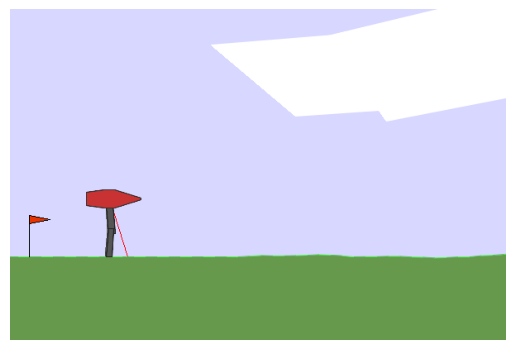

In [ ]:
## SETUP

# make env
if hardcore == False:
  env = rld.make("rldurham/Walker", render_mode="rgb_array")
else:
  env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="nchw73-agent-hardcore-video" if hardcore else "nchw73-agent-video",  # prefix for videos
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, params['action_dim'], params['state_dim'] = rld.env_info(env, print_out=True) # note: state_dim = obs_dim
params['max_action'] = float(env.action_space.high[0]) # Jinghao: this is used to scale the agent's actions to ensure they stay in action space

# render start image
env.reset(seed=seed)
rld.render(env)

**Training**

In [232]:
# in the submission please use seed_everything with seed 42 for verification
seed, state, info = rld.seed_everything(seed, env)

# track statistics for plotting
tracker = rld.InfoTracker()

env.video = False # switch video recording off (only switch on every x episodes as this is slow)

replay_buffer = EREReplayBuffer(params['state_dim'], params['action_dim'], max_timesteps)

actor = Actor(params['state_dim'], params['action_dim'])

critic = Critic(params['state_dim'], params['action_dim'], n_quantiles, n_nets)
critic_target = copy.deepcopy(critic)

dreamer = DreamerAgent(params['state_dim'], params['action_dim'], hidden_dim, window_size, num_layers, num_heads, dropout_prob)

class_to_take_gradient_step = Gradient_Step(
    actor=actor, critic=critic, critic_target=critic_target,
    top_quantiles_to_drop = top_quantiles_to_drop_per_net * n_nets, # total number of quantiles to drop
    discount=discount, tau=tau,
    target_entropy=-np.prod(env.action_space.shape).item(), 
    quantiles_total = n_quantiles * n_nets)

actor.train()

ep_timesteps = 0
total_steps = 0
ep_reward = 0
memory_ptr = 0 # marks boundary between new and old data in the replay buffer
train_set, test_set = None, None
reward_list = []
reward_avg_list = []
# plot_data = []
ep_timesteps_dreamer = ep_reward_dreamer = dreamer_eps = 0
current_size = 0

Seed set to 42


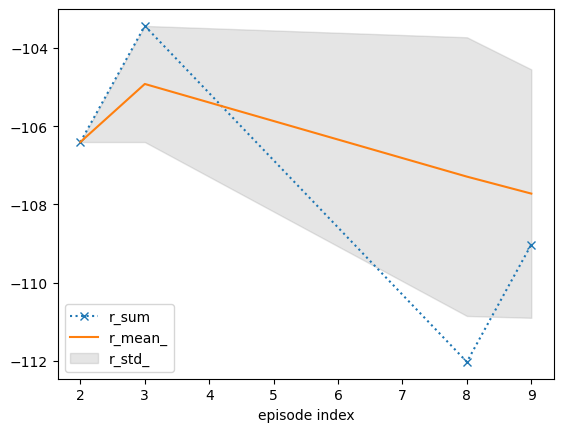

Ep: 10 | Episode T: 50 | Reward: -111.711 | Dreamer: False
Ep: 11 | Episode T: 53 | Reward: -112.237 | Dreamer: False
Ep: 12 | Episode T: 62 | Reward: -112.441 | Dreamer: False
Ep: 13 | Episode T: 2000 | Reward: -45.276 | Dreamer: False


KeyboardInterrupt: 

In [ ]:
# training procedure
for episode in range(1, max_episodes+1): # index from 1
    # recording statistics and video can be switched on and off (video recording is slow!)
    if is_recording and episode >= ep_start_rec:
        env.info = episode % video_every == 0   # track every x episodes (usually tracking every episode is fine)
        env.video = episode % video_every == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    state, info = env.reset()

    # sample real env
    ep_timesteps, ep_reward, input_buffer, info = train_on_environment(
        actor, env, class_to_take_gradient_step, replay_buffer, max_timesteps, state,
        batch_size, total_steps, window_size)

    total_steps += ep_timesteps
    tracker.track(info) # track statistics for plotting

    # update train/test sets for dreamer (add new eps and trim to window size)
    train_set, test_set = gen_test_train_seq(
        replay_buffer, train_set, test_set, train_split, window_size, step_size, memory_ptr)

    # train dreamer after ep_thresh and if the input buffer has enough data to fill context window
    if episode >= episode_threshold and input_buffer.shape[0] == window_size:
        # train and assess the dreamer every train_frequency
        if episode % dreamer_train_frequency == 0:
            dreamer.train_dreamer(train_set, dreamer_train_epochs, batch_size_dreamer)

        # truncate the training set to control train time performance
        if test_set.shape[0] > max_size:
            train_set = train_set[-max_size:]

        print('Size of sequences: ', train_set.shape[0], test_set.shape[0])
        
        # evaluate the dreamer's performance & decide num of training steps for dreamer
        dreamer_avg_loss = dreamer.test_dreamer(test_set, batch_size_dreamer)
        dreamer_eps = get_dreamer_eps(dreamer_avg_loss, score_threshold)

        # train on dreamer if its accurate enough
        if dreamer_eps > 0:
            print(f'Dreamer active for {dreamer_eps} iterations')
            ep_timesteps_dreamer = ep_reward_dreamer = 0
            for dep in range(dreamer_eps): # (dep = dreamer episode)
                print(f'Dreamer ep: {dep+1}')

                # initialise dreamer states with the input sequence
                dreamer.states = input_buffer[:, :params['state_dim']]
                dreamer.actions = input_buffer[:-1, params['state_dim']:params['state_dim']+params['action_dim']]
                dreamer.rewards = input_buffer[:-1, -2-params['state_dim']].unsqueeze(1)
                dreamer.dones = input_buffer[:-1, -1-params['state_dim']].unsqueeze(1)

            # sample from dreamer environment (ignore input buffer and info)
            _td, _rd, _, _ = train_on_environment(
                actor, dreamer, class_to_take_gradient_step, replay_buffer,
                math.ceil(total_steps/episode) - 1, dreamer.states[-1].cpu().numpy(),
                batch_size, total_steps, window_size)

            ep_timesteps_dreamer += _td
            ep_reward_dreamer += _rd

    memory_ptr = replay_buffer.ptr # update the memory pointer to the current position in the buffer

    print(f"Ep: {episode} | Ep tsteps: {ep_timesteps} | Reward: {ep_reward:.3f} | Dreamer: {dreamer_eps > 0}")
    if dreamer_eps > 0:
        print(f"\t Dreamer Eps: {dreamer_eps} | Dreamer Avg Timesteps: {ep_timesteps_dreamer/dreamer_eps} | Dreamer Avg Reward: {ep_reward_dreamer/dreamer_eps}")

    reward_list.append(ep_reward)
    reward_avg_list.append(ep_reward)
    ep_reward = 0

    # plot tracked statistics (on real env)
    if episode % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

    # break condition - stop if we consistently meet target score
    if len(reward_avg_list) == 100:
        print(f'Current progress: {np.array(reward_avg_list).mean()}/{target_score}')
        if np.array(reward_avg_list).mean() >= target_score: # quit when we've got (basically) optimal performance
            print('Completed environment!')
            break
        reward_avg_list = reward_avg_list[-99:] # discard oldest on list

if save_model:
    torch.save(actor.state_dict(), './model.pth')

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
if hardcore:
    filename = "nchw73-agent-hardcore-log.txt"
else:
    filename = "nchw73-agent-log.txt"
env.write_log(folder="logs", file=filename)
